# Examing the effects of dynamic creators

In [1]:
from trecs.components import Creators, Users, Items
from trecs.models import ContentFiltering, PopularityRecommender
import numpy as np
from collections import defaultdict

In [2]:
# parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import create_profiles, calc_group_preferences, cos_sim_score_fn
from dynamic_creators import DynamicCreators
from custom_metrics import CreatorAvgGroupSkew

In [3]:
user_profiles, item_profiles, creator_profiles = create_profiles(
    total_users = 100,
    num_majority_users = 80,
    total_items = 10,
    num_majority_items = 5,
    total_creators = 100,
    dynamic_creators = True,
    creation_probability = 1.0,
    num_attrs = 6,
    separate_attr = True,
    group_strength= 1.0,
    creator_learning_rate = 0.01,
)

Percentage of items generated by Group A: 0.5


In [5]:
calc_group_preferences(user_profiles, item_profiles, 80, 1)

Members of Group A prefer items from group A 73.66% of the time.
Members of Group B prefer items from group A 28.33% of the time.


In [6]:
cf = ContentFiltering(
    actual_item_representation=item_profiles,
    item_representation=item_profiles,
#     actual_user_representation=Users(actual_user_profiles=user_profiles, score_fn=cos_sim_score_fn),
    actual_user_representation=Users(actual_user_profiles=user_profiles),
    creators = creator_profiles,
    num_items_per_iter=15
)
cf.add_metrics(CreatorAvgGroupSkew())
# randomly interleave as many as 10 random items per timestep
cf.run(timesteps=200, random_items_per_iter=10, vary_random_items_per_iter=True)

100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


In [7]:
group_attr = np.array(cf.get_measurements()['creator_group_skew'][1:])

In [8]:
print(group_attr.mean(axis=1))

[0.56853536 0.57375293 0.57623219 0.58193219 0.58584456 0.59151422
 0.59643449 0.60143047 0.60713047 0.61256628 0.61759836 0.62235844
 0.62704396 0.63114396 0.63548101 0.63988101 0.64407852 0.64808542
 0.65074957 0.6525945  0.65688247 0.66138247 0.66447444 0.66760376
 0.67034125 0.67268923 0.67392046 0.67626084 0.67806084 0.68067129
 0.68214423 0.68464423 0.68691694 0.68798734 0.68968734 0.69148734
 0.69273231 0.69376769 0.69546769 0.69720101 0.69980101 0.70073073
 0.70153073 0.70255936 0.70315936 0.70435936 0.70537936 0.7069167
 0.7077167  0.7082167  0.70949837 0.71189837 0.7129713  0.71303984
 0.71323984 0.71357745 0.71496571 0.71524658 0.71584658 0.71634627
 0.7167476  0.71872299 0.71912299 0.71952299 0.71962299 0.71965442
 0.71995442 0.72075442 0.72095442 0.72165442 0.72155442 0.72174405
 0.72264405 0.72164405 0.72124405 0.72214405 0.72214405 0.72324917
 0.72344917 0.72394917 0.72344917 0.72334917 0.72434022 0.72424022
 0.72484022 0.72499729 0.72499729 0.72486531 0.72556531 0.72546

In [9]:
creator_profiles.actual_creator_profiles.mean(axis=0)

array([0.6218436 , 0.54480225, 0.56897971, 0.67022955, 0.7449582 ])

## Does cosine similarity score function make a noticeable difference?

Notice that all attributes of content creators seem to increase past 0.5 for the normal dot product user scoring. My working hypothesis is that content producers are driven to extremal values of each attribute because all else equal, this means increased utility for their items on that particular attribute. I tried using cosine similarity instead to see if this would resolve the issue.

In [13]:
user_profiles, item_profiles, creator_profiles = create_profiles(
    total_users = 100,
    num_majority_users = 80,
    total_items = 10,
    num_majority_items = 5,
    total_creators = 100,
    dynamic_creators = True,
    creation_probability = 1.0,
    num_attrs = 6,
    separate_attr = True,
    group_strength= 1.0,
    creator_learning_rate = 0.01,
)

Percentage of items generated by Group A: 0.5


In [14]:
print(user_profiles.shape, item_profiles.shape, creator_profiles.actual_creator_profiles.shape)

(100, 6) (6, 10) (100, 5)


In [15]:
calc_group_preferences(user_profiles, item_profiles, 80, 1)

Members of Group A prefer items from group A 80.28% of the time.
Members of Group B prefer items from group A 26.05% of the time.


In [16]:
# notice we pass in cos_sim_score_fn to Usres initialization
cf = ContentFiltering(
    actual_item_representation=item_profiles,
    item_representation=item_profiles,
    actual_user_representation=Users(actual_user_profiles=user_profiles, score_fn=cos_sim_score_fn),
    creators = creator_profiles,
    num_items_per_iter=15
)
cf.add_metrics(CreatorAvgGroupSkew())
# randomly interleave as many as 10 random items per timestep
cf.run(timesteps=200, random_items_per_iter=10, vary_random_items_per_iter=True)

100%|██████████| 200/200 [00:22<00:00,  8.99it/s]


In [17]:
creator_profiles.actual_creator_profiles.mean(axis=0)

array([0.49140364, 0.58699344, 0.49386203, 0.58288541, 0.69318604])

Let's do this test a bit more systematically.

In [18]:
creator_mean_dot = []
creator_mean_cos = []

for i in range(50):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=15,
        verbose=True
    )
    cf.run(timesteps=200, random_items_per_iter=10, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    creator_mean_dot.append(mean_creator)
    # cosine
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles, score_fn=cos_sim_score_fn),
        creators = creator_profiles,
        num_items_per_iter=15
    )
    cf.run(timesteps=200, random_items_per_iter=10, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    creator_mean_cos.append(mean_creator)

  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 10/200 [00:00<00:03, 56.66it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  2%|▎         | 5/200 [00:00<00:08, 24.18it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  3%|▎         | 6/200 [00:00<00:05, 33.89it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 10/200 [00:00<00:03, 55.05it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:03, 50.15it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:04, 42.07it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:04, 40.54it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:03, 48.60it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:03, 49.04it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:03, 49.93it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  2%|▎         | 5/200 [00:00<00:07, 25.14it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:04, 44.62it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:04, 39.58it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 10/200 [00:00<00:03, 50.41it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▎         | 7/200 [00:00<00:05, 35.75it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  3%|▎         | 6/200 [00:00<00:07, 25.23it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:04, 41.06it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 8/200 [00:00<00:05, 38.09it/s]

Percentage of items generated by Group A: 0.5


  3%|▎         | 6/200 [00:00<00:04, 44.63it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:04, 40.08it/s]

Percentage of items generated by Group A: 0.5


  2%|▎         | 5/200 [00:00<00:07, 24.70it/s]

Percentage of items generated by Group A: 0.5


  3%|▎         | 6/200 [00:00<00:05, 33.19it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  4%|▍         | 9/200 [00:00<00:04, 45.02it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


In [19]:
print(f"Mean creator profile over 50 simulations using dot product: {np.vstack(creator_mean_dot).mean(axis=0)}")
print(f"Mean creator profile over 50 simulations using cosine sim: {np.vstack(creator_mean_cos).mean(axis=0)}")

Mean creator profile over 50 simulations using dot product: [0.59929146 0.60124188 0.59339519 0.58588821 0.69097257]
Mean creator profile over 50 simulations using cosine sim: [0.5282188  0.53566507 0.52907797 0.52269125 0.69841611]


That seems to help. For now let's go with cosine similarity and note this down as an important quirk.

# Animate creators over time 

Randomly sample 25 creators and chart their trajectories.

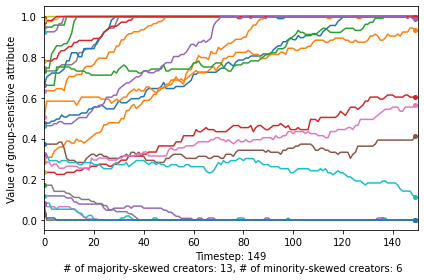

In [30]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

fig, ax = plt.subplots()
fig.set_tight_layout(True)
ax.set(xlim=(0, 150), ylim=(-0.05, 1.05))
ax.set_ylabel("Value of group-sensitive attribute")

# sample 25 creators
creators = np.random.choice(100, 25, replace=False)
lines = []

def init():
    for c in creators:
        lines.append(ax.plot(group_attr[:1, c], 'o', ls='-', ms=4, markevery=[-1])[0])

def animate(t):
    num_1 = 0
    num_0 = 0
    for i, c in enumerate(creators):
        lines[i].set_data(np.arange(t+1), group_attr[:t+1, c])
        if group_attr[t, c] >= 1.0:
            num_1 += 1
        elif group_attr[t, c] <= 0.0:
            num_0 += 1
    ax.set_xlabel(f"Timestep: {t}\n # of majority-skewed creators: {num_1}, # of minority-skewed creators: {num_0}")
    return ax
    
    
anim = FuncAnimation(
    fig, animate, frames=np.arange(0, 150), interval=100, init_func=init)
 
# plt.draw()
# plt.show()
anim.save('creator_trajectories.gif', writer='imagemagick')

In [4]:
group_strengths = [0, 0.5, 1.0, 2.5]
majority_props = [0.5, 0.6, 0.7, 0.8, 0.9]

# setting up
total_users = 100
total_items = 10
num_majority_items = 5
total_creators = 100
creation_probability = 1.0
num_attrs = 6
learning_rate = 0.01

results_cos = {}
results_dot = {}
for group_strength in group_strengths:
    for majority_prop in majority_props:
        mean_trajectory = []
        print(f"Testing group strength {group_strength} and majority proportion {majority_prop}...")
        for i in range(30):
            user_profiles, item_profiles, creator_profiles = create_profiles(
                total_users = total_users,
                num_majority_users = round(majority_prop*total_users),
                total_items = total_items,
                num_majority_items = num_majority_items,
                total_creators = total_creators,
                dynamic_creators = True,
                creation_probability = creation_probability,
                num_attrs = num_attrs,
                separate_attr = True,
                group_strength=group_strength,
                creator_learning_rate = learning_rate,
                verbose=False,
            )
            cf = ContentFiltering(
                actual_item_representation=item_profiles,
                item_representation=item_profiles,
                actual_user_representation=Users(actual_user_profiles=user_profiles, score_fn=cos_sim_score_fn),
#                 actual_user_representation=Users(actual_user_profiles=user_profiles),
                creators = creator_profiles,
                num_items_per_iter=15,
                verbose=True
            )
            cf.add_metrics(CreatorAvgGroupSkew())
            # randomly interleave as many as 10 random items per timestep
            cf.run(timesteps=200, random_items_per_iter=10, vary_random_items_per_iter=True)
            group_attr = np.array(cf.get_measurements()['creator_group_skew'][1:]).mean(axis=1).reshape(1, -1)
            mean_trajectory.append(group_attr)

        results_cos[(group_strength, majority_prop)] = np.vstack(mean_trajectory).mean(axis=0)

  4%|▍         | 8/200 [00:00<00:02, 69.32it/s]

Testing group strength 0 and majority proportion 0.5...


  3%|▎         | 6/200 [00:00<00:07, 27.41it/s]

Testing group strength 0 and majority proportion 0.6...


  3%|▎         | 6/200 [00:00<00:06, 32.33it/s]

Testing group strength 0 and majority proportion 0.7...


  3%|▎         | 6/200 [00:00<00:06, 29.11it/s]

Testing group strength 0 and majority proportion 0.8...


  0%|          | 0/200 [00:00<?, ?it/s]

Testing group strength 0 and majority proportion 0.9...


  3%|▎         | 6/200 [00:00<00:06, 28.35it/s]

Testing group strength 0.5 and majority proportion 0.5...


  3%|▎         | 6/200 [00:00<00:06, 30.84it/s]

Testing group strength 0.5 and majority proportion 0.6...


  3%|▎         | 6/200 [00:00<00:06, 30.64it/s]

Testing group strength 0.5 and majority proportion 0.7...


  3%|▎         | 6/200 [00:00<00:06, 30.32it/s]

Testing group strength 0.5 and majority proportion 0.8...


  3%|▎         | 6/200 [00:00<00:05, 33.20it/s]

Testing group strength 0.5 and majority proportion 0.9...


  2%|▎         | 5/200 [00:00<00:06, 29.30it/s]

Testing group strength 1.0 and majority proportion 0.5...


  0%|          | 0/200 [00:00<?, ?it/s]

Testing group strength 1.0 and majority proportion 0.6...


  0%|          | 0/200 [00:00<?, ?it/s]

Testing group strength 1.0 and majority proportion 0.7...


  3%|▎         | 6/200 [00:00<00:06, 31.22it/s]

Testing group strength 1.0 and majority proportion 0.8...


  2%|▎         | 5/200 [00:00<00:07, 27.78it/s]

Testing group strength 1.0 and majority proportion 0.9...


  3%|▎         | 6/200 [00:00<00:06, 28.17it/s]

Testing group strength 2.5 and majority proportion 0.5...


  3%|▎         | 6/200 [00:00<00:05, 33.04it/s]

Testing group strength 2.5 and majority proportion 0.6...


  3%|▎         | 6/200 [00:00<00:06, 32.21it/s]

Testing group strength 2.5 and majority proportion 0.7...


  0%|          | 0/200 [00:00<?, ?it/s]

Testing group strength 2.5 and majority proportion 0.8...


  0%|          | 0/200 [00:00<?, ?it/s]

Testing group strength 2.5 and majority proportion 0.9...


100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


## What's going on with dot product?

Issue: we see that using the dot product causes *all* attributes of the creator profile to increase, when we expect that only the group-sensitive attribute should increase systematically. 

Thought experiment: let's say there are 10 user attributes (the first 9 are not group-sensitive, while the last 1 is the group-sensitive attribute). The EV of any item is $\mathbb{E}[u_j \cdot i_k]$, where $u_j$ and $i_k$ represent the user and item vectors. We can simplify to $\mathbb{E}[u_1\cdot i_1 + u_2\cdot i_2 + \dots + u_{10}\cdot i_{10}]$, which then simplifies to $\sum^{10}_{j=1} \mathbb{E}[u_j \cdot i_j] = \sum^{10}_{j=1} \mathbb{E}[u_j]\cdot \text{Pr}[i_j=1]$. (We can separate the expectation into two expectations because the random variables are independent; user profiles are generated independently from the initial creator profiles.)

From `../utils.py`:
```
user_profiles = np.random.uniform(low=-1.0, high=1.0, size=(total_users, num_attrs))
```

**New theory**: The issue is the implementation of content filtering recommendations, which allows the user representation to grow arbitrarily large. Hmm...perhaps the content filtering training algorithm itself should use cosine similarity when updating? Or try using a more conventional implementation of CF?

In [10]:
user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 100,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )

# test independence of group-sensitive item attribute and other item attributes
# in initial item set
item_profiles_1 = item_profiles[:, item_profiles[5, :] == 1.0]
item_profiles_0 = item_profiles[:, item_profiles[5, :] == 0.0]
print(item_profiles_1.mean(axis=1))
print(item_profiles_0.mean(axis=1))

Percentage of items generated by Group A: 0.05
[0.49779172 0.57470691 0.4614122  0.50976017 0.         1.        ]
[0.65239899 0.37719262 0.50526363 0.37609272 1.         0.        ]


In [3]:
dot_creator_profs = []

for i in range(20):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.run(timesteps=100, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs.append(mean_creator)
   

  5%|▌         | 5/100 [00:00<00:01, 49.86it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 5/100 [00:00<00:01, 49.67it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 5/100 [00:00<00:03, 31.18it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 5/100 [00:00<00:01, 49.78it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  5%|▌         | 5/100 [00:00<00:03, 31.67it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


In [4]:
print(f"Mean creator profile over 20 simulations using modified version of dot product: {np.vstack(dot_creator_profs).mean(axis=0)}")

Mean creator profile over 50 simulations using modified version of dot product: [0.57034893 0.57360143 0.55586789 0.55966871 0.6376401 ]


Show only random items at each timestep.

In [5]:
dot_creator_profs = []

for i in range(20):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.run(timesteps=100, random_items_per_iter=10, vary_random_items_per_iter=False)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs.append(mean_creator)
   

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  7%|▋         | 7/100 [00:00<00:02, 33.48it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  6%|▌         | 6/100 [00:00<00:02, 32.55it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  6%|▌         | 6/100 [00:00<00:01, 48.77it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  6%|▌         | 6/100 [00:00<00:02, 32.93it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 100/100 [00:03<00:00, 30.22it/s]


In [6]:
print(f"Mean creator profile over 20 simulations using only random recommendations: {np.vstack(dot_creator_profs).mean(axis=0)}")

Mean creator profile over 50 simulations using modified version of dot product: [0.49456452 0.50655961 0.49945851 0.49939143 0.68304819]


Interesting. So when we show random items, only the group-sensitive attribute increases (as expected). But when we use the content filtering algo, all of the attributes start to increase.

What about random first, then content filtering?

In [12]:
dot_creator_profs_rand = []
dot_creator_profs_after_cf = []

for i in range(20):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.startup_and_train(timesteps=50)
    # record creator profiles after random matching
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_rand.append(mean_creator)
    # record creator profiles after CF algorithm
    cf.run(timesteps=150, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_after_cf.append(mean_creator)
   

 14%|█▍        | 7/50 [00:00<00:00, 61.04it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 32.41it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 14%|█▍        | 7/50 [00:00<00:01, 35.96it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 33.50it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.50it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 29.01it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 32.02it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.36it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 10%|█         | 5/50 [00:00<00:01, 31.37it/s]

Percentage of items generated by Group A: 0.5


 10%|█         | 5/50 [00:00<00:01, 30.55it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.41it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


In [13]:
print(f"Mean creator profile over 20 simulations with 50 timesteps of random recommendation: {np.vstack(dot_creator_profs_rand).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 150 timesteps of CF after random: {np.vstack(dot_creator_profs_after_cf).mean(axis=0)}")

Mean creator profile over 20 simulations with 50 timesteps of random recommendation: [0.49099709 0.50015527 0.49552388 0.49774995 0.63142293]
Mean creator profile over 20 simulations with 150 timesteps of CF after random: [0.54839387 0.55867241 0.56266029 0.56330383 0.6854518 ]


Neat! So the problem is confirmed to be the CF implementation. We see the attributes increasing in value when we use the content filtering algorithm, but when it's only random, the problem doesn't rear its head

Next idea: try to observe the average creator profile at various points in the training.

In [14]:
dot_creator_profs_cf_100 = []
dot_creator_profs_cf_200 = []
dot_creator_profs_cf_300 = []

for i in range(20):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.startup_and_train(timesteps=50)
    # record creator profiles after CF algorithm
    cf.run(timesteps=100, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_100.append(mean_creator)
    
    cf.run(timesteps=200, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_200.append(mean_creator)
    
    cf.run(timesteps=300, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_300.append(mean_creator)
   

  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  1%|▏         | 4/300 [00:01<01:34,  3.14it/s]/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.sin((1.0 - perc) * omega) / sin_o * mat1_norm.T
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:112: RuntimeWarning: invalid value encountered in true_divide
  + np.sin(perc * omega) / sin_o * mat2_norm.T
  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 300/300 [02:31<00:00,  1.98it/s]


In [15]:
print(f"Mean creator profile over 20 simulations with 100 timesteps of CF: {np.vstack(dot_creator_profs_cf_100).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 200 timesteps of CF: {np.vstack(dot_creator_profs_cf_200).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 300 timesteps of CF: {np.vstack(dot_creator_profs_cf_300).mean(axis=0)}")

Mean creator profile over 20 simulations with 100 timesteps of CF: [0.54383517 0.54620042 0.55828353 0.55541738 0.69767219]
Mean creator profile over 20 simulations with 200 timesteps of CF: [0.55797302 0.55304945 0.57420982 0.56287882 0.72040295]
Mean creator profile over 20 simulations with 300 timesteps of CF: [0.5596911  0.55291287 0.57882598 0.56451028 0.73053465]


Realization: whether using the modified CF `recommender.users_hat` update function (which uses vector rotation) or the original version (which is additive for each vector), the issue is that `users_hat` is never really incremented in the _negative_ direction for any value.

Original version: true user profiles distributed between 0 and 1, 1 for group attribute; items produced have attributes 0 or 1; simple additive `users_hat` update rule
* Content creators who "game the system" notice that user profiles are always _positive_ - therefore, increasing the propensity for all variables to be 1 can only benefit them according to the CF system, as that will strictly increase the predicted utility for each user
* Observe non-group attributes "tilting" to 1

Modified version: true user profiles distributed between -1 and 1, 1 for group attribute; items produced have attributes 0 or 1; rotational `users_hat` udpate rule
* Items all have 0 or 1, if user profiles are updated to look more like items, then content creators will game system to maximize all attributes

Can we fix things by biasing items to only have values between -0.5 and 0.5 instead?

Test: true user profiles distributed between -1 and 1, 1 for group attribute; items produced have attributes -0.5 or 0.5; simple additive `users_hat` update rule (use `main` branch of `trecs`, not `content-filtering-slerp`)

In [3]:
dot_creator_profs_cf_50_rand = []
dot_creator_profs_cf_100 = []
dot_creator_profs_cf_200 = []

for i in range(25):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
        item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.startup_and_train(timesteps=50)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_50_rand.append(mean_creator)
    
    # record creator profiles after CF algorithm
    cf.run(timesteps=100, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_100.append(mean_creator)
    
    cf.run(timesteps=200, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_200.append(mean_creator)
    

 16%|█▌        | 8/50 [00:00<00:00, 66.29it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 14%|█▍        | 7/50 [00:00<00:00, 63.44it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 14%|█▍        | 7/50 [00:00<00:00, 68.34it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 33.29it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


In [4]:
print(f"Mean creator profile over 20 simulations with 50 timesteps of random warmup: {np.vstack(dot_creator_profs_cf_50_rand).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 100 timesteps of CF: {np.vstack(dot_creator_profs_cf_100).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 200 timesteps of CF: {np.vstack(dot_creator_profs_cf_200).mean(axis=0)}")

Mean creator profile over 20 simulations with 50 timesteps of random warmup: [0.50098273 0.49050618 0.49229414 0.49151609 0.59592074]
Mean creator profile over 20 simulations with 100 timesteps of CF: [0.47669548 0.47453698 0.46931225 0.46515256 0.65801501]
Mean creator profile over 20 simulations with 200 timesteps of CF: [0.45953958 0.4619684  0.45459222 0.44929713 0.69925526]


Hmm, now it seems like the other attributes are being driven to 0 when we switch from random warmup to CF. I wonder what gives... Let's do a different test now.

Test: true user profiles distributed between -1 and 1, 1 for group attribute; items produced have attributes -0.5 or 0.5; rotational vector update rule (`content-filtering-slerp` branch of `trecs`)

In [36]:
dot_creator_profs_cf_50_rand = []
dot_creator_profs_cf_100 = []
dot_creator_profs_cf_200 = []

for i in range(20):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
        item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.startup_and_train(timesteps=50)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_50_rand.append(mean_creator)
    
    # record creator profiles after CF algorithm
    cf.run(timesteps=100, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_100.append(mean_creator)
    
    cf.run(timesteps=200, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_200.append(mean_creator)
    

 12%|█▏        | 6/50 [00:00<00:00, 56.07it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:02, 17.18it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 54.10it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 52.52it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:05,  7.67it/s]

Percentage of items generated by Group A: 0.5


 14%|█▍        | 7/50 [00:00<00:00, 62.14it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 30.68it/s]

Percentage of items generated by Group A: 0.5


 14%|█▍        | 7/50 [00:00<00:00, 62.49it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 52.30it/s]

Percentage of items generated by Group A: 0.5


 95%|█████████▌| 190/200 [00:41<00:02,  3.66it/s]/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.sin((1.0 - perc) * omega) / sin_o * mat1_norm.T
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:112: RuntimeWarning: invalid value encountered in true_divide
  + np.sin(perc * omega) / sin_o * mat2_norm.T
  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 54.05it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 46.16it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.25it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.32it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 46.41it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:00, 46.95it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 31.06it/s]

Percentage of items generated by Group A: 0.5


 12%|█▏        | 6/50 [00:00<00:01, 25.82it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


In [37]:
print(f"Mean creator profile over 20 simulations with 50 timesteps of random warmup: {np.vstack(dot_creator_profs_cf_50_rand).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 100 timesteps of CF: {np.vstack(dot_creator_profs_cf_100).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 200 timesteps of CF: {np.vstack(dot_creator_profs_cf_200).mean(axis=0)}")

Mean creator profile over 20 simulations with 50 timesteps of random warmup: [0.49018283 0.50698507 0.50165001 0.49743807 0.58415308]
Mean creator profile over 20 simulations with 100 timesteps of CF: [0.46052314 0.48307821 0.47970542 0.47680497 0.64542459]
Mean creator profile over 20 simulations with 200 timesteps of CF: [0.4413033  0.46696207 0.46494992 0.46028064 0.68729543]


Detour: visualizing recommended items to see if that will help us understand why non-group sensitive attributes also change over time, once the recommender kicks into gear.

In [9]:
item_indices = cf.indices
# for each user, eliminate items that have been interacted with
item_indices = item_indices[np.where(item_indices >= 0)]
item_indices = item_indices.reshape((cf.num_users, -1))

recs = cf.generate_recommendations(k=10, item_indices=item_indices)

In [12]:
cf.items[:, recs[1, :]]

array([[ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]])

In [14]:
cf.users.actual_user_profiles[1,:]

ActualUserProfiles([ 0.97150376, -0.02068017, -0.14865952, -0.45528944,
                     1.        ,  0.        ])

In [15]:
cf.users.actual_user_profiles[1,:] @ cf.items[:, recs[1, :]]

ActualUserProfiles([1.29806645, 1.29806645, 1.29806645, 1.29806645,
                    1.29806645, 1.29806645, 1.29806645, 1.29806645,
                    1.29806645, 1.29806645])

In [18]:
cf.items[:, recs[2, :]]

array([[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]])

In [19]:
cf.users.actual_user_profiles[2,:]

ActualUserProfiles([-0.32163404,  0.44665181,  0.8214317 , -0.41904656,
                     1.        ,  0.        ])

In [17]:
cf.users.actual_user_profiles[2,:] @ cf.items[:, recs[2, :]]

ActualUserProfiles([1.50438206, 1.50438206, 1.50438206, 1.50438206,
                    1.50438206, 1.50438206, 1.50438206, 1.50438206,
                    1.50438206, 1.50438206])

In [21]:
cf.users.actual_user_profiles.mean(axis=0)

ActualUserProfiles([-0.0433092 ,  0.07319361, -0.04214129, -0.02479472,
                     0.8       ,  0.2       ])

In [22]:
cf.creators.actual_creator_profiles.mean(axis=0).reshape(1, -1)

array([[0.3791597 , 0.43526483, 0.44403084, 0.45533434, 0.69566527]])

In [ ]:
# examine average value of attribute across all recommendations
all_recs = []
for i in range(recs.shape[0]): # iterate over all recommendations given to users
    all_recs.append(cf.items[:, recs[i, :]])

# print(all_recs)
np.hstack(all_recs).mean(axis=1)

Try training a single model, run random startup, then inspect recommendations at the next iteration.

In [3]:
user_profiles, item_profiles, creator_profiles = create_profiles(
    total_users = 100,
    num_majority_users = 80,
    total_items = 10,
    num_majority_items = 5,
    total_creators = 100,
    dynamic_creators = True,
    creation_probability = 1.0,
    num_attrs = 6,
    separate_attr = True,
    group_strength= 1.0,
    creator_learning_rate = 0.01,
    item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
)
cf = ContentFiltering(
    actual_item_representation=item_profiles,
    item_representation=item_profiles,
    actual_user_representation=Users(actual_user_profiles=user_profiles),
    creators = creator_profiles,
    num_items_per_iter=10,
    verbose=True
)
cf.startup_and_train(timesteps=50)

 16%|█▌        | 8/50 [00:00<00:00, 73.07it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 50/50 [00:01<00:00, 27.47it/s]


In [4]:
item_indices = cf.indices
# for each user, eliminate items that have been interacted with
item_indices = item_indices[np.where(item_indices >= 0)]
item_indices = item_indices.reshape((cf.num_users, -1))

recs = cf.generate_recommendations(k=10, item_indices=item_indices)

In [5]:
cf.items.shape

(6, 5010)

In [6]:
cf.items[:, recs].mean(axis=2).mean(axis=1)

array([ 0.01061338, -0.02712164, -0.03447166, -0.04310035,  0.315     ,
       -0.285     ])

In [7]:
cf.items[:, cf.users.get_user_feedback(
    items_shown=recs, item_attributes=cf.items
)].T.mean(axis=0)

array([ 0.05432989,  0.01258542,  0.01163975,  0.01868569,  0.38      ,
       -0.22      ])

In [8]:
creator_profiles_0 = cf.creators.actual_creator_profiles.copy()

In [9]:
creator_profiles_0

array([[0.1870722 , 0.84208903, 0.        , 0.03024936, 0.29567307],
       [0.90647865, 0.98398664, 1.        , 1.        , 0.68898607],
       [1.        , 0.17960456, 0.        , 0.45732144, 0.0163771 ],
       [0.73230193, 0.22296507, 0.91253299, 0.06553793, 0.00911815],
       [1.        , 1.        , 0.38588979, 0.45347575, 0.89610966],
       [0.99339507, 0.        , 0.83240452, 0.52742604, 0.10524493],
       [0.34224595, 0.94179609, 1.        , 0.        , 0.07166907],
       [0.        , 0.95608429, 0.91224616, 1.        , 0.62206585],
       [1.        , 0.33757751, 0.71304047, 0.13364369, 0.4756601 ],
       [0.        , 0.        , 0.9403205 , 0.14168917, 1.        ],
       [1.        , 0.        , 1.        , 0.03554271, 1.        ],
       [0.30677889, 0.96643693, 0.33899111, 1.        , 0.80623729],
       [1.        , 0.        , 0.        , 0.49050699, 1.        ],
       [0.41768656, 0.54887079, 0.16644143, 0.88243233, 0.94501526],
       [0.6803687 , 0.10106258, 0.

In [10]:
creator_profiles = [creator_profiles_0]
for i in range(10):
    cf.run(timesteps=1, random_items_per_iter=4, vary_random_items_per_iter=True)
    creator_profiles_1 = cf.creators.actual_creator_profiles.copy()
    print((creator_profiles_1 - creator_profiles[-1]).mean(axis=0))
    creator_profiles.append(creator_profiles_1)

  0%|          | 0/1 [00:00<?, ?it/s]

[-0.0002  -0.00025 -0.00065 -0.00065  0.00145]
[ 2.89863686e-05 -3.00000000e-04 -4.45510992e-04 -1.50000000e-04
  1.38268272e-03]


  0%|          | 0/1 [00:00<?, ?it/s]

[-0.00040401 -0.0002     -0.00052477 -0.0003      0.00173267]
[-0.00025 -0.0002  -0.00035 -0.0004   0.00165]


  0%|          | 0/1 [00:00<?, ?it/s]

[ 0.00046605 -0.00025    -0.0008     -0.0007      0.0014    ]
[-5.27163959e-04  5.00000000e-05 -6.48646335e-04 -7.27503691e-04
  1.15000000e-03]


  0%|          | 0/1 [00:00<?, ?it/s]

[-1.0000000e-04  1.0000000e-04 -6.0000000e-04 -9.2867085e-04
  1.3248646e-03]
[ 0.00025    -0.0002     -0.00068284 -0.00030249  0.00107081]


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

[-0.0002  -0.0002  -0.0003  -0.0005   0.00095]
[-1.00000000e-04 -2.39116716e-04 -8.00000000e-04 -5.00000000e-04
  1.20000000e-03]


In [11]:
print("Change in majority creators for 10 timesteps")
for i in range(1, len(creator_profiles)):
    # just look at majority creators
    maj_creator_index = creator_profiles[i][:, -1] == 1.0
    cur_maj_creators = creator_profiles[i][maj_creator_index, :]
    prev_maj_creators = creator_profiles[i-1][maj_creator_index, :]
    print((cur_maj_creators - prev_maj_creators).mean(axis=0))
    
print()
print("Change in minority creators for 10 timesteps")
for i in range(1, len(creator_profiles)):
    # just look at majority creators
    min_creator_index = creator_profiles[i][:, -1] < 0.3
    cur_min_creators = creator_profiles[i][maj_creator_index, :]
    prev_min_creators = creator_profiles[i-1][maj_creator_index, :]
    print((cur_min_creators - prev_min_creators).mean(axis=0))
    

Change in majority creators for 10 timesteps
[-0.00125    -0.000625    0.00020833 -0.00020833  0.        ]
[-0.00088405 -0.0008      0.00050838 -0.0014      0.00053073]
[-0.00038462  0.00019231 -0.00115385 -0.00096154  0.00012564]
[-0.00019231  0.00019231  0.00019231 -0.00076923  0.        ]
[ 0.0006  0.0006 -0.0018 -0.0012  0.    ]
[-0.0012 -0.0006 -0.0016 -0.0012  0.    ]
[-1.92307692e-03  1.34615385e-03 -2.11538462e-03 -2.41796481e-03
  9.56330939e-05]
[ 0.00089286 -0.00035714 -0.00065301 -0.00196429  0.00039996]
[-3.57142857e-04  1.23908820e-19 -4.21289987e-18 -3.57142857e-04
  0.00000000e+00]
[-3.57142857e-04  2.17440300e-04  4.95635279e-19 -1.78571429e-03
  0.00000000e+00]

Change in minority creators for 10 timesteps
[-0.00107143 -0.00071429  0.00035714  0.          0.00035714]
[-0.00078933 -0.00071429  0.00045391 -0.00125     0.00047387]
[-3.57142857e-04  2.47817639e-19 -1.25000000e-03 -1.07142857e-03
  2.95238786e-04]
[-0.00017857  0.00035714  0.00035714 -0.00053571  0.0005357

More timesteps???

In [12]:
dot_creator_profs_cf_50_rand = []
dot_creator_profs_cf_100 = []
dot_creator_profs_cf_500 = []

for i in range(25):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
        item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
    )
    cf = ContentFiltering(
        actual_item_representation=item_profiles,
        item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=True
    )
    cf.startup_and_train(timesteps=50)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_50_rand.append(mean_creator)
    
    # record creator profiles after CF algorithm
    cf.run(timesteps=100, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_100.append(mean_creator)
    
    cf.run(timesteps=500, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    dot_creator_profs_cf_500.append(mean_creator)
    

 16%|█▌        | 8/50 [00:00<00:00, 73.38it/s]

Percentage of items generated by Group A: 0.5


 42%|████▏     | 208/500 [00:55<01:41,  2.88it/s]/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.sin((1.0 - perc) * omega) / sin_o * mat1_norm.T
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:112: RuntimeWarning: invalid value encountered in true_divide
  + np.sin(perc * omega) / sin_o * mat2_norm.T
  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


 46%|████▋     | 232/500 [01:01<01:14,  3.60it/s]/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/matrix_ops.py:97: RuntimeWarning: invalid value encountered in arccos
  omega = np.arccos(row_dot_product)
  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


In [13]:
print(f"Mean creator profile over 20 simulations with 50 timesteps of random warmup: {np.vstack(dot_creator_profs_cf_50_rand).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 100 timesteps of CF: {np.vstack(dot_creator_profs_cf_100).mean(axis=0)}")
print(f"Mean creator profile over 20 simulations with 200 timesteps of CF: {np.vstack(dot_creator_profs_cf_500).mean(axis=0)}")

Mean creator profile over 20 simulations with 50 timesteps of random warmup: [0.48789796 0.50433042 0.50415929 0.4956754  0.59944275]
Mean creator profile over 20 simulations with 100 timesteps of CF: [0.46645889 0.47754755 0.48201732 0.47919713 0.65687146]
Mean creator profile over 20 simulations with 200 timesteps of CF: [0.45110786 0.4643395  0.46755206 0.47162011 0.71169866]


Smaller example with 50 users and 10 creators.

In [23]:
user_profiles, item_profiles, creator_profiles = create_profiles(
    total_users = 50,
    num_majority_users = 40,
    total_items = 10,
    num_majority_items = 5,
    total_creators = 10,
    dynamic_creators = True,
    creation_probability = 1.0,
    num_attrs = 6,
    separate_attr = True,
    group_strength= 1.0,
    creator_learning_rate = 0.001,
    item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
)
cf = ContentFiltering(
    actual_item_representation=item_profiles,
    item_representation=item_profiles,
    actual_user_representation=Users(actual_user_profiles=user_profiles),
    creators = creator_profiles,
    num_items_per_iter=10,
    verbose=True
)
cf.startup_and_train(timesteps=10)

100%|██████████| 10/10 [00:00<00:00, 146.08it/s]

Percentage of items generated by Group A: 0.5


In [24]:
print(cf.creators.actual_creator_profiles.copy())
print(cf.creators.actual_creator_profiles.copy().mean(axis=0))

[[0.94685395 0.95846833 0.0532058  0.34450078 0.69756644]
 [0.04995795 0.87592353 0.26265872 0.95993388 0.69336316]
 [0.82588739 0.42715734 0.36647666 0.42364512 0.67626462]
 [0.44502148 0.50143334 0.56440653 0.31839913 0.69161907]
 [0.87531127 0.2636872  0.23484471 0.88236879 0.96967049]
 [0.3601287  1.         0.90261743 0.50953526 0.29225024]
 [0.62290348 0.6764781  0.50221519 0.74602895 0.78634629]
 [0.58972736 0.03800763 0.57560906 0.63786971 0.55656695]
 [0.76238138 0.33143881 0.74144448 0.81321148 0.02108667]
 [0.40598121 0.32308497 0.37278491 0.39291412 0.7554369 ]]
[0.58841542 0.53956792 0.45762635 0.60284072 0.61401708]


In [25]:
cf.run(timesteps=500, random_items_per_iter=4, vary_random_items_per_iter=True)

100%|██████████| 500/500 [00:13<00:00, 36.35it/s]


In [26]:
print(cf.creators.actual_creator_profiles.copy())
print(cf.creators.actual_creator_profiles.copy().mean(axis=0))

[[1.         0.86346833 0.         0.16750078 0.67456644]
 [0.         1.         0.23965872 1.         0.95136316]
 [1.         0.         0.         0.         1.        ]
 [0.03202148 0.78143334 0.99740653 0.         1.        ]
 [1.         0.         0.         1.         1.        ]
 [0.         1.         1.         0.38903526 0.41675024]
 [0.69390348 0.5914781  0.74721519 0.86802895 1.        ]
 [0.58172736 0.         1.         1.         1.        ]
 [0.70088138 0.07593881 0.86494448 0.94271148 0.        ]
 [0.25998121 0.         0.57678491 0.34391412 1.        ]]
[0.52685149 0.43123186 0.54260098 0.57111906 0.80426798]


Ultimately, I was unable to figure out a good reason for why I'm seeing the effects I'm seeing in the CF simulations. We know that it's there, and that the random recommendations yield expected effects, but not sure otherwise. For now, I'll try popularity simulations.

# Dynamic content creators + popularity recommender system

Test: true user profiles distributed between -1 and 1, 1 for group attribute; items produced have attributes -0.5 or 0.5 (`main` branch of t-recs)

In [35]:
creator_profs_pop = []

for i in range(25):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength= 1.0,
        creator_learning_rate = 0.01,
        item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
    )
    pop = PopularityRecommender(
        actual_item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=False
    )
    pop.startup_and_train(timesteps=25)
    
    # record creator profiles after CF algorithm
    pop.run(timesteps=300, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    creator_profs_pop.append(mean_creator)
    

  2%|▏         | 7/300 [00:00<00:04, 60.41it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  1%|          | 2/300 [00:00<00:17, 17.10it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  2%|▏         | 6/300 [00:00<00:05, 52.76it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of items generated by Group A: 0.5


100%|██████████| 300/300 [00:36<00:00,  8.14it/s]


In [33]:
print(f"Mean creator profile over 20 simulations with 300 timesteps of popularity: {np.vstack(creator_profs_pop).mean(axis=0)}")

Mean creator profile over 20 simulations with 200 timesteps of popularity: [0.48716486 0.48691649 0.49697533 0.4884444  0.55635124]


Interestingly, creator attributes don't change as much...is this because only the top creators see their incentives change?

In [ ]:
creator_profs_pop = []

for i in range(1):
    # dot product
    user_profiles, item_profiles, creator_profiles = create_profiles(
        total_users = 100,
        num_majority_users = 80,
        total_items = 10,
        num_majority_items = 5,
        total_creators = 100,
        dynamic_creators = True,
        creation_probability = 1.0,
        num_attrs = 6,
        separate_attr = True,
        group_strength=5.0,
        creator_learning_rate = 0.01,
        item_bias=-0.5 # IMPORTANT: this ensures generated items will be between -0.5 and 0.5
    )
    pop = PopularityRecommender(
        actual_item_representation=item_profiles,
        actual_user_representation=Users(actual_user_profiles=user_profiles),
        creators = creator_profiles,
        num_items_per_iter=10,
        verbose=False
    )
    pop.startup_and_train(timesteps=25)
    
    # record creator profiles after CF algorithm
    pop.run(timesteps=300, random_items_per_iter=4, vary_random_items_per_iter=True)
    mean_creator = creator_profiles.actual_creator_profiles.mean(axis=0).reshape(1, -1)
    creator_profs_pop.append(mean_creator)
    

  2%|▏         | 6/300 [00:00<00:04, 59.23it/s]

Percentage of items generated by Group A: 1.0


 20%|██        | 61/300 [00:02<00:13, 17.83it/s]

In [ ]:
print(f"Mean creator profile over 20 simulations with 300 timesteps of popularity: {np.vstack(creator_profs_pop).mean(axis=0)}")

In [ ]:
item_indices = pop.indices
# for each user, eliminate items that have been interacted with
item_indices = item_indices[np.where(item_indices >= 0)]
item_indices = item_indices.reshape((pop.num_users, -1))

recs = pop.generate_recommendations(k=10, item_indices=item_indices)

In [ ]:
pop.items[:, recs[1, :]].T